In [56]:
#Libraries
from __future__ import annotations
import math
from IPython.display import clear_output, display
import requests
import getpass
from sentinelhub import SHConfig
import datetime
import os
import matplotlib.pyplot as plt
from typing import Any
from pandas import to_datetime, date_range
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    bbox_to_resolution,
    transform_point,
    get_utm_crs,
    aws,
    SentinelHubCatalog,
    Geometry,
)

#Makes it possible to plot in vusual studio
%matplotlib widget
#plt.rcParams["figure.figsize"] = [1.25, 6.50]

In [50]:
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]

access_token = get_access_token(
    "olivermillinge@live.dk",
    getpass.getpass("Enter your password: "),
)

In [12]:
"""Setup of sentinel client credentials (for the given Copernicus hub is used)
Following links are used:
https://sentinelhub-py.readthedocs.io/en/latest/configure.html                  //Configuration
https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html   //Data request setup
https://sentinelhub-py.readthedocs.io/en/latest/examples/data_collections.html  //Setup
https://dataspace.copernicus.eu/news/2023-9-28-accessing-sentinel-mission-data-new-copernicus-data-space-ecosystem-apis
https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.geometry.html //Geometry
"""

#First we need to setup the configuration for the sentinelhub
config = SHConfig()                                                            #Configuration Class
config_location = SHConfig.get_config_location()                               #Location of the configuration file
config.instance_id = "OliverML"                                                 #Profile id
config.sh_client_id = "sh-f74155bc-d801-4214-b465-91dccbf00e36"                   #ID for OAuth from sentinelhub
config.sh_client_secret = "dOtgNKKlBsQYry8Gxt3u78WvgiqzvDsI"           #Secret for OAuth from sentinelhub
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("OliverML")                                                         #Saves data to the config file

print(config)
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use process API, please provide the credentials (OAuth client ID and client Secret)")

{
  "instance_id": "********",
  "sh_client_id": "***********************************0e36",
  "sh_client_secret": "****************************vDsI",
  "sh_base_url": "https://sh.dataspace.copernicus.eu",
  "sh_auth_base_url": null,
  "sh_token_url": "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1
}


In [49]:
config = SHConfig("OliverML")
for collection in DataCollection.get_available_collections():
    collection.service_url = config.sh_base_url

In [6]:
#---------------FUNCTIONS------------------#

#Plotting function
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

def zoom(img, x, y, zoom):
    w, h = 1250, 650
    L, H  = w/zoom, h / zoom
    x1, x2, y1, y2 = np.ceil(abs(x - L/2)),np.ceil(abs(x + L/2)), np.ceil(abs(y - H/2)), np.ceil(abs(y + H/2))
    print(x1,x2,y1,y2)
    image = img[int(y1):int(y2), int(x1):int(x2)]
    print(image.shape)
    image = cv2.resize(image, (w, h))
    print(image.shape)
    return image

#Functions for collecting the data
def collect_data(time_interval, AOI, Size, config, evalscript, datacollection):
    request = SentinelHubRequest(evalscript = evalscript,
                                input_data = [
                                    SentinelHubRequest.input_data(
                                        data_collection=datacollection,
                                        time_interval=time_interval,
                                    )
                                ],
                                responses = [SentinelHubRequest.output_response("default", MimeType.PNG )],
                                                                                bbox=AOI,
                                                                                size=Size,
                                                                                config=config,
                                                                                    )
    image = request.get_data()

    return image

#Function to sort out the data that isn't complete or overlapping dates of the loaded polygons
def extract_possible_dates(time_interval, coords, config, datacollection):
    catalog = SentinelHubCatalog(config=config)
    aoi_bbox = BBox(bbox=coords, crs=CRS.WGS84)
    search_iterator = catalog.search(
            datacollection,
            bbox=aoi_bbox,
            time=time_interval,
            fields={"include": ["geometry.coordinates", "properties.datetime"], "exclude": []},
        )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    dates = [pd.to_datetime(result["properties"]["datetime"]).date().strftime("%Y-%m-%d") for result in results]
    print(dates)
    coordinates = [result['geometry']["coordinates"][0] for result in results ]
    collected_coords = []
    for d in dict.fromkeys(dates):
            collected_coords.append([coordinates[dates.index(d)+c] for c in range(dates.count(d))])
    multipolyray = []
    for i in range(len(collected_coords)):
        temp_poly_array = []
        for l in range(len(collected_coords[i][:])):
            multicoordray = []
            for s in collected_coords[i][l]:
                multicoordray.append((s[0],s[1]))
            temp_poly_array.append(Polygon(multicoordray))
        if len(temp_poly_array) != 1: 
            multipolyray.append(unary_union(temp_poly_array))
        else:
            multipolyray.append(temp_poly_array[0])

    location = Polygon(((coords[0],coords[1]),
                        (coords[2],coords[1]),
                        (coords[2],coords[3]),
                        (coords[0],coords[1]),
                        (coords[0],coords[1])))

    is_in = gpd.GeoSeries(multipolyray).contains(location)
    i = 0
    possible_dates = dict.fromkeys(dates)

    for d in possible_dates:
        print(f'date {d} is in {is_in[i]}')
        i +=1 
    
    dates = [date for date, is_in_value in zip(possible_dates, is_in) if is_in_value]
    print(dates)
    return dates

#Function to extract the dates with overlapping polygons
def extract_dates(time_interval, coords, config, datacollection):
    catalog = SentinelHubCatalog(config=config)
    aoi_bbox = BBox(bbox=coords, crs=CRS.WGS84)
    search_iterator = catalog.search(
            datacollection,
            bbox=aoi_bbox,
            time=time_interval,
            fields={"include": ["geometry.coordinates", "properties.datetime"], "exclude": []},
        )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    dates = [pd.to_datetime(result["properties"]["datetime"]).date().strftime("%Y-%m-%d") for result in results]
    
    return dates

#Function to calculate the parameters for the data collection
def calculate_parameters(BBCoords, ImWidth, ImHeight, resolution, time_interval, datacollection, filtered):
    CoordBBox = BBox(bbox=BBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system          
    BBoxSize = bbox_to_dimensions(CoordBBox, resolution = resolution)  #Size of the bbox    
    if filtered == True:
        dates = list(reversed(dict.fromkeys(extract_possible_dates(
            time_interval, BBCoords, config, datacollection))))           #Finds the amount of dates available and fully complete
    else:
        dates = list(reversed(dict.fromkeys(extract_dates(
            time_interval, BBCoords, config, datacollection))))            #Finds the amount of dates available that arent fully complete
    
    total_possible_days = len(dates)                                    #Total amount of days available

    CoordsUtm1 = transform_point((BBCoords[0], BBCoords[1]),source_crs = CRS.WGS84,
                             target_crs = get_utm_crs(BBCoords[0], BBCoords[1]))
    CoordsUtm2 = transform_point((BBCoords[2], BBCoords[3]),source_crs = CRS.WGS84
                                ,target_crs = get_utm_crs(BBCoords[2], BBCoords[3]))

    UTMBBox = BBox(bbox=(CoordsUtm1[0], CoordsUtm1[1], CoordsUtm2[0], CoordsUtm2[1]), crs = get_utm_crs(BBCoords[0], BBCoords[1]))
    utm_BBoxSize = bbox_to_dimensions(UTMBBox, resolution = resolution)

    Distance_utmx, Distance_utmy = abs(CoordsUtm1[0] - CoordsUtm2[0]), abs(CoordsUtm1[1] - CoordsUtm2[1])

    partition_size_x = Distance_utmx * ((ImWidth/utm_BBoxSize[0]))   
    partition_size_y = Distance_utmy * ((ImHeight/utm_BBoxSize[1]))  #Lat / Long coordinates difference and resolution scale.

    BBoxPartition = UTMBBox.get_partition(size_x=partition_size_x,
                                            size_y=partition_size_y)  #Partition of the bbox for the data collection

    for i in range(len(BBoxPartition)):
        for j in range(len(BBoxPartition[0][:])):
            BBoxPartition[i][j] = BBox.transform(BBoxPartition[i][j], crs = CRS.WGS84)
    
    res_up = bbox_to_resolution(BBoxPartition[0][0], width=ImWidth, height=ImHeight)     #Resolution update to end up with 1250x650 image
    reBBoxSize = bbox_to_dimensions(BBoxPartition[0][0], resolution = res_up)              #Size of the bbox at the updated resolution

    ReBBCoords = (BBoxPartition[0][-1].upper_right[0],
            BBoxPartition[0][-1].upper_right[1],
            BBoxPartition[-1][0].lower_left[0],
            BBoxPartition[-1][0].lower_left[1])
    CoordReBBox = BBox(bbox=ReBBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system        
    ogReBBoxSize = bbox_to_dimensions(CoordReBBox, resolution = res_up)  #Size of the bbox at the updated resolution

    print(f"\nImage shape at {resolution} m resolution: {BBoxSize} pixels\n")
    print(f'\nResized image shape at {res_up} m resolution: {ogReBBoxSize} pixels\n')
    print(f"\nResized image shape at ")
    print(f'Partition size: {reBBoxSize} pixels, with resolution {res_up} m and shape {len(BBoxPartition)} x {len(BBoxPartition[0][:])} partitions.\n')
    #print(f'resolution error percentage: in x {round(abs(res_up[0]/resolution*100-100),2)}%, in y: {(round(abs(res_up[1]/resolution*100-100),2))} %\n')
    print(f'Original bbox coordinates: {BBCoords}, Partioned BBox coordinates: {BBoxPartition[0][0].upper_right[0],BBoxPartition[0][0].upper_right[1], BBoxPartition[-1][-1].lower_left[0],BBoxPartition[-1][-1].lower_left[1]}\n')
    return dates, res_up, total_possible_days, BBoxPartition, reBBoxSize

def median_filter(img):
    #https://likegeeks.com/median-filter-numpy-python/ - Code taken from here
    kernel_size = 7
    kernel = np.ones((kernel_size,kernel_size),dtype=np.uint8)

    half_kernel_size = kernel_size // 2
    padded_image = np.pad(img, pad_width=half_kernel_size, mode='constant', constant_values=0)
    filtered_image = np.zeros_like(padded_image)
    print(padded_image[1].shape, padded_image[1].shape, padded_image[:,1].shape)
    for i in range(half_kernel_size, padded_image.shape[0] - half_kernel_size):
        for j in range(half_kernel_size, padded_image.shape[1] - half_kernel_size):
            window = padded_image[i - half_kernel_size:i + half_kernel_size + 1, j - half_kernel_size:j + half_kernel_size + 1]
            filtered_image[i, j] = np.median(window)

    filtered_image = filtered_image[half_kernel_size:-half_kernel_size, half_kernel_size:-half_kernel_size]
    
    print(filtered_image.shape, half_kernel_size, padded_image.shape, img.shape)
    return filtered_image

In [54]:
#-----------------PARAMETER SETUP-----------------#

#.................Coord database..................#
#BBCoords = (-19.368896,74.630926,-11.282959,75.898801)            #Coordinates of Bbox, found with bboxfinder
#BBCoords = (-21.390381,78.009607,-11.041260,79.369728)
#BBCoords = (-18.154907,75.294947,-17.045288,75.493030)
#BBCoords = (-18.874512,74.375554,-13.974609,76.087595)            #useless so far
#BBCoords = (-17.237549,75.696646,-15.930176,74.99641)             #Only Oil spill
#BBCoords = (-17.737549,75.696646,-13.830176,72.99641)  #Really long region of oil spill, not good
#..................................................#

BBCoords = (-17.737549,75.696646,-13.830176,72.99641)
ImWidth, ImHeight = 320, 320                                      #Image width and height
resolution = (80,80)                                               #Resolution of the data
time_interval = "2023-09-28", "2023-09-28"                         #Time interval for the data
datacollection = DataCollection.SENTINEL1                          #Data collection to be used: s1, s1ew
mydpi = 96                                                         #DPI for plotting the images                    

#The following parameters are calculated:
# - Dates being the dates with data available, and total_possible_days being the amount of days.
# - Res_up being the resolution of the partioned data
# - BBoxPartition are the partioned BBox for the given coordinates corresponding to 1250x650 pixels
#     The Bbox area is divided into parts BBoxPartition[i][j]

dates, res_up, total_possible_days, BBoxPartition, reBBoxSize = calculate_parameters(BBCoords, ImWidth, ImHeight, resolution, time_interval, datacollection, filtered = False)
#---------------------------------------------------#

#The evalscripts are collected from sentinelhub or copernicushub and determine the SAR parameters of the collected data
#Below are two different types.

evalscript1 = """
    //VERSION=3
    function setup() {
        return {
            input: ["HH", "dataMask"],
            output: { bands: 4 }
        }
    }

    function evaluatePixel(sample) {
        var value = 2 * sample.HH;
        value = Math.min(5, Math.max(-30, value));
        return [value, value, value, sample.dataMask];
    }
    """

evalscript2 ="""
//VERSION=3
function setup() {
  return {
    input: ["HH", "dataMask"],
    output: { bands: 4 }
  }
}

function evaluatePixel(sample) {
  const value = Math.max(0, Math.log(sample.HH) * 0.21714724095 + 1);
  return [value, value, value, sample.dataMask];
}

// ---
/*
// displays HH in decibels from -20 to 0
// the following is simplified below
// var log = 10 * Math.log(HH) / Math.LN10;
// var val = Math.max(0, (log + 20) / 20);

return [Math.max(0, Math.log(HH) * 0.21714724095 + 1)];
*/"""

Total number of results: 4

Image shape at (80, 80) m resolution: (1520, 3744) pixels


Resized image shape at (79.98030792087211, 79.99786782047303) m resolution: (1024, 3824) pixels


Resized image shape at 
Partition size: (320, 320) pixels, with resolution (79.98030792087211, 79.99786782047303) m and shape 5 x 12 partitions.

Original bbox coordinates: (-17.737549, 75.696646, -13.830176, 72.99641), Partioned BBox coordinates: (-16.54829543300637, 73.22344605196669, -14.03592500896153, 75.52178293235167)



Total frames: 60
Image loaded
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (320, 320, 4)


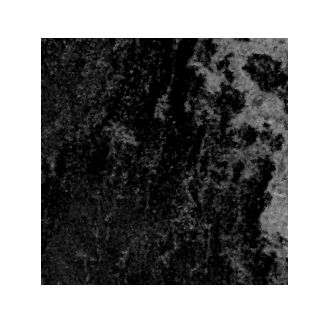

In [47]:
#Plotting and datacollection from the given parameters. The resulting will be a gif of the possible dates in the area of the bbox
anim = []
visualize_days = False
#bbox_cr, bbox_cc = math.floor(len(BBoxPartition)/2), math.floor(len(BBoxPartition[0][:])/2)
#print(bbox_cr, bbox_cc)

if visualize_days == True:
    BBCoordsp = (BBoxPartition[0][0].upper_right[0],
                BBoxPartition[0][0].upper_right[1],
                BBoxPartition[-1][-1].lower_left[0],
                BBoxPartition[-1][-1].lower_left[1])
    CoordBBox = BBox(bbox=BBCoordsp, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system        
    ogBBoxSize = bbox_to_dimensions(CoordBBox, resolution = 40)
    fig, ax = plt.subplots(dpi=mydpi, frameon=False)
    ax.axis('off')

    for i in range(total_possible_days):
        local_time_interval = dates[i], dates[i]
        frame = collect_data(local_time_interval, CoordBBox,
                            ogBBoxSize, config, evalscript2, datacollection)
        im = ax.imshow(frame[0], animated=True)
        if i == 0:
            ax.imshow(frame[-1])
        anim.append([im])
        print(f'Image {i+1} loaded')
        ani = animation.ArtistAnimation(fig = fig, artists = anim, interval=3000, blit=True, repeat_delay=0)

else:
    print(f'Total frames: {len(BBoxPartition)*len(BBoxPartition[0][:])}')
    fig, ax = plt.subplots(figsize=(ImWidth/mydpi, ImHeight/mydpi), dpi=mydpi, frameon=False)
    ax.axis('off')
    local_time_interval = dates[0], dates[0]
    for i in range(len(BBoxPartition)):
        for j in range(len(BBoxPartition[0][:])):
            frame = collect_data(local_time_interval, BBoxPartition[i][j],
                                reBBoxSize, config, evalscript2, datacollection)
            im = ax.imshow(frame[0], animated=True)
            if i == 0:
                ax.imshow(frame[-1])
            anim.append([im])
    print(f'Image loaded')
    ani = animation.ArtistAnimation(fig = fig, artists = anim, interval=500, repeat_delay=0)

print(f"Returned data is of type = {type(frame)} and length {len(frame)}.")
print(f"Single element in the list is of type {type(frame[-1])} and has shape {frame[-1].shape}")

0.0 1250.0 0.0 650.0
(320, 320, 4)
(650, 1250, 4)


(-0.5, 1249.5, 649.5, -0.5)

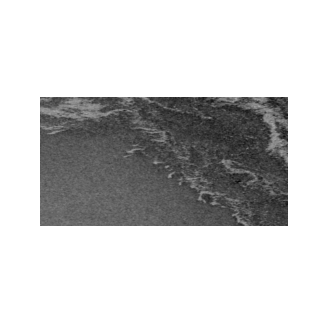

In [59]:
#Single image
import cv2
import scipy.ndimage as ndimage

plt.close('all')
fig, ax = plt.subplots(figsize=(ImWidth/mydpi, ImHeight/mydpi), dpi=mydpi, frameon=False)

bbox_cr, bbox_cc = math.floor(len(BBoxPartition)/2), math.floor(len(BBoxPartition[0][:])/2)

fig.set_size_inches(ImWidth/mydpi, ImHeight/mydpi)
local_time_interval = dates[0], dates[0]
frame = collect_data(local_time_interval, BBoxPartition[bbox_cr][bbox_cc],
                        reBBoxSize, config, evalscript2, datacollection)
"""frame[0] = frame[0]/255
kernel1 = np.array([[-1,-1,-1],
                    [-1,9,-1],
                    [-1,-1,-1]])
kernel2 = np.array([[0,-0.5,0],
                    [-0.5,2.5,-0.5],
                    [0,-0.5,0]])
for channel in range(3):
    filtered_frame[:,:,channel] = ndimage.median_filter(frame[0][:,:,channel], size=7, mode ="nearest")
filtered_frame = np.copy(frame[0])"""
im = ax.imshow(zoom(frame[0], 625, 325, 1))
ax.axis('off')






In [ ]:
# plt.close('all')
print(f"Single element in the list is of type {type(frame[-1])} and has shape {frame[-1].shape}")

Single element in the list is of type <class 'numpy.ndarray'> and has shape (650, 1250, 4)


(663, 1268)
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1268, 663, 4)


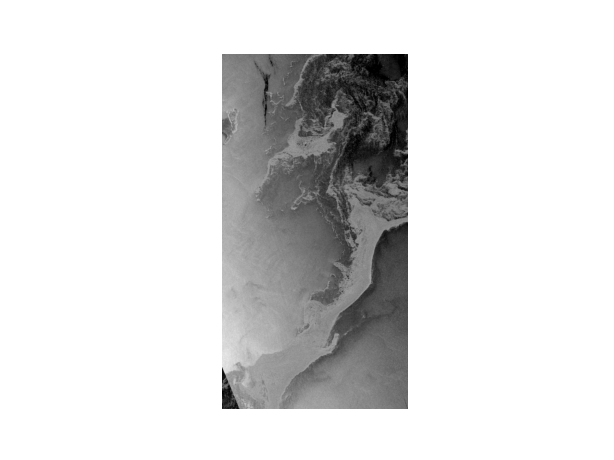

In [60]:
#Single image (just chosen area)
BBCoords = (BBoxPartition[0][-1].lower_left[0],
            BBoxPartition[0][-1].lower_left[1],
            BBoxPartition[-1][0].upper_right[0],
            BBoxPartition[-1][0].upper_right[1])

CoordBBox = BBox(bbox=BBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system   
ogBBoxSize = bbox_to_dimensions(CoordBBox, resolution = 200)
print(ogBBoxSize)
fig, ax = plt.subplots(dpi=mydpi, frameon=False)
factor = 3                                  #Factor for the image brightness

local_time_interval = dates[0], dates[0]

frame = collect_data(local_time_interval, CoordBBox,
                        ogBBoxSize, config, evalscript2, datacollection)

#print(zoom(frame[-1],np.ceil(4197) , np.ceil(8237), 10).shape)
im = ax.imshow(frame[-1])
ax.axis('off')
print(f"Single element in the list is of type {type(frame[-1])} and has shape {frame[-1].shape}")

In [ ]:
#Run this to save the currently loaded gif
date1str, date2str, coordstr = str(time_interval[0]), str(time_interval[1]), str(BBCoords)
ani.save('os_'+ date1str + '_to_' + date2str + '_' + coordstr + '.gif', writer='imagemagick', fps=1, dpi=mydpi)

"""
im = Image.fromarray(frame[0]*factor)
im.save()"""

MovieWriter imagemagick unavailable; using Pillow instead.


'\nim = Image.fromarray(frame[0]*factor)\nim.save()'

In [ ]:
#Run this to save the currently loaded png
date1str, date2str, coordstr = str(time_interval[0]), str(time_interval[1]), str(BBCoords)
fig.savefig('os_'+ date1str + '_to_' + date2str + '_' + coordstr + '.png', dpi=mydpi)

In [ ]:
"""Helpful command list:


#### Get available data collections ####
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)
DataCollection.SENTINEL2_L1C


"""

In [ ]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL
DataCollection.cophub


In [ ]:
CoordBBox = BBox(bbox=BBCoords, crs=CRS.WGS84)                     
BBoxSize = bbox_to_dimensions(CoordBBox, resolution = resolution)  

CoordsUtm1 = transform_point((BBCoords[0], BBCoords[1]),source_crs = CRS.WGS84,
                             target_crs = get_utm_crs(BBCoords[0], BBCoords[1]))
CoordsUtm2 = transform_point((BBCoords[2], BBCoords[3]),source_crs = CRS.WGS84
                             ,target_crs = get_utm_crs(BBCoords[2], BBCoords[3]))

UTMBBox = BBox(bbox=(CoordsUtm1[0], CoordsUtm1[1], CoordsUtm2[0], CoordsUtm2[1]), crs = get_utm_crs(BBCoords[0], BBCoords[1]))
utm_BBoxSize = bbox_to_dimensions(UTMBBox, resolution = resolution)

Distance_utmx, Distance_utmy = abs(CoordsUtm1[0] - CoordsUtm2[0]), abs(CoordsUtm1[1] - CoordsUtm2[1])

partition_size_x = Distance_utmx * ((ImWidth/utm_BBoxSize[0]))   
partition_size_y = Distance_utmy * ((ImHeight/utm_BBoxSize[1]))  #Lat / Long coordinates difference and resolution scale.

BBoxPartition = UTMBBox.get_partition(size_x=partition_size_x,
                                        size_y=partition_size_y)  #Partition of the bbox for the data collection

for i in range(len(BBoxPartition)):
    for j in range(len(BBoxPartition[0][:])):
        BBoxPartition[i][j] = BBox.transform(BBoxPartition[i][j], crs = CRS.WGS84)
res_up = bbox_to_resolution(BBoxPartition[0][0], width=ImWidth, height=ImHeight)     #Resolution update to end up with 1250x650 image
reBBoxSize = bbox_to_dimensions(BBoxPartition[0][0], resolution = res_up)              #Size of the bbox at the updated resolution

print(f"Image shape at {resolution} m resolution: {BBoxSize} pixels")
print(f'Partition size: {reBBoxSize} pixels, with resolution {res_up} m and shape {len(BBoxPartition)} x {len(BBoxPartition[0][:])} partitions.')
print(f'resolution error percentage: in x {round(abs(res_up[0]/resolution*100-100),2)}%, in y: {(round(abs(res_up[1]/resolution*100-100),2))} %')

print(BBoxPartition[0][0].upper_right)
    

8323374.133484206 8403084.013684804 424529.28571342246 476010.9669095038
Image shape at (20, 19.5) m resolution: (2809, 3921) pixels
Partition size: (1250, 650) pixels, with resolution (20.00065314533063, 19.49850298449254) m and shape 3 x 7 partitions.


TypeError: unsupported operand type(s) for /: 'float' and 'tuple'

Shape:[[0.49411765 0.49411765 0.49411765]
 [0.47058824 0.47058824 0.47058824]
 [0.55686275 0.55686275 0.55686275]
 ...
 [0.30980392 0.30980392 0.30980392]
 [0.28627451 0.28627451 0.28627451]
 [0.29019608 0.29019608 0.29019608]]


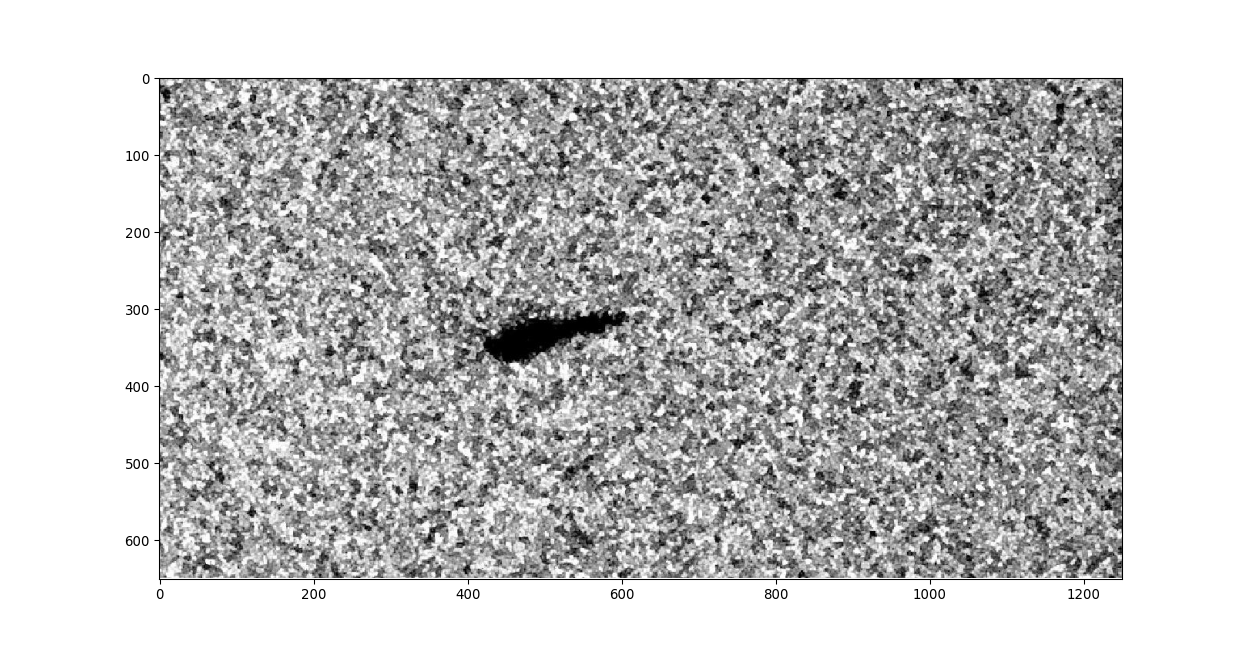

In [ ]:
dataim = cv2.imread("C:/Users/olive/OneDrive/Skrivebord/Elektroteknologi/6. Semester/Bachelor/Project/Machine Learning Model/dataset/test/images/img_0008.jpg")
fig, ax = plt.subplots(figsize=(ImWidth/mydpi, ImHeight/mydpi), dpi=mydpi, frameon=False)
ax.imshow(dataim)